# Hugging Face Object Detection FineTuning with DETR
- Fine-tuning detr-resnet-50 with CPPE datasets

# References
- https://huggingface.co/docs/transformers/tasks/object_detection

# Data
- The CPPE-5 dataset contains images with annotations identifying medical personal protective equipment (PPE) in the context of the COVID-19 pandemic.
- https://huggingface.co/datasets/cppe-5

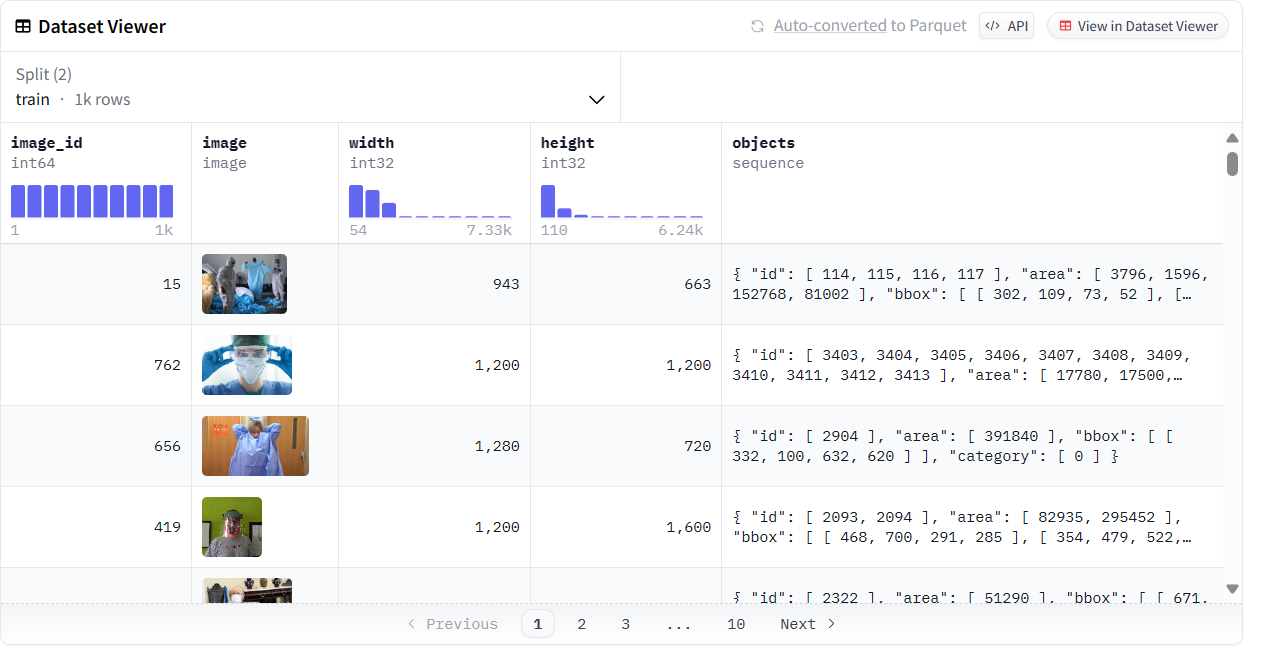

In [3]:
from datasets import load_dataset

cppe5 = load_dataset("cppe-5")

Plotting a sample of the loaded data

In [4]:
cppe5["train"][0]

{'image_id': 15,
 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=943x663>,
 'width': 943,
 'height': 663,
 'objects': {'id': [114, 115, 116, 117],
  'area': [3796, 1596, 152768, 81002],
  'bbox': [[302.0, 109.0, 73.0, 52.0],
   [810.0, 100.0, 57.0, 28.0],
   [160.0, 31.0, 248.0, 616.0],
   [741.0, 68.0, 202.0, 401.0]],
  'category': [4, 4, 0, 0]}}

The examples in the dataset have the following fields:

- image_id: the example image id
- image: a PIL.Image.Image object containing the image
- width: width of the image
- height: height of the image
- objects: a dictionary containing bounding box metadata for the objects in the image:
    - id: the annotation id
    - area: the area of the bounding box
    - bbox: the object’s bounding box (in the COCO format )
    - category: the object’s category, with possible values including Coverall (0), Face_Shield (1), Gloves (2), Goggles (3) and Mask (4)

You may notice that the bbox field follows the COCO format, which is the format that the DETR model expects. However, the grouping of the fields inside objects differs from the annotation format DETR requires. You will need to apply some preprocessing transformations before using this data for training.

To get an even better understanding of the data, visualize an example in the dataset.

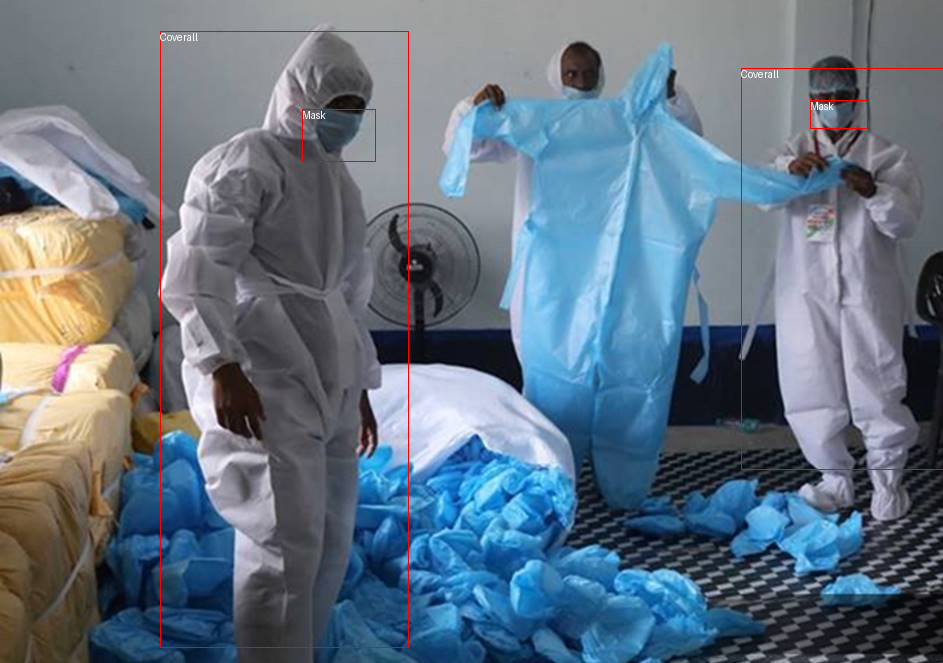

In [5]:
import numpy as np
import os
from PIL import Image, ImageDraw

image = cppe5["train"][0]["image"]
annotations = cppe5["train"][0]["objects"]
draw = ImageDraw.Draw(image)

categories = cppe5["train"].features["objects"].feature["category"].names

id2label = {index: x for index, x in enumerate(categories, start=0)}
label2id = {v: k for k, v in id2label.items()}

for i in range(len(annotations["id"])):
    box = annotations["bbox"][i]
    class_idx = annotations["category"][i]
    x, y, w, h = tuple(box)
    # Check if coordinates are normalized or not
    if max(box) > 1.0:
        # Coordinates are un-normalized, no need to re-scale them
        x1, y1 = int(x), int(y)
        x2, y2 = int(x + w), int(y + h)
    else:
        # Coordinates are normalized, re-scale them
        x1 = int(x * width)
        y1 = int(y * height)
        x2 = int((x + w) * width)
        y2 = int((y + h) * height)
    draw.rectangle((x, y, x + w, y + h), outline="red", width=1)
    draw.text((x, y), id2label[class_idx], fill="white")

image

As a final step of getting familiar with the data, explore it for potential issues. One common problem with datasets for object detection is bounding boxes that “stretch” beyond the edge of the image. Such “runaway” bounding boxes can raise errors during training and should be addressed at this stage. There are a few examples with this issue in this dataset. To keep things simple in this guide, we remove these images from the data.

In [6]:
remove_idx = [590, 821, 822, 875, 876, 878, 879]
keep = [i for i in range(len(cppe5["train"])) if i not in remove_idx]
cppe5["train"] = cppe5["train"].select(keep)

# Preprocess the Image
To finetune a model, you must preprocess the data you plan to use to match precisely the approach used for the pre-trained model. AutoImageProcessor takes care of processing image data to create pixel_values, pixel_mask, and labels that a DETR model can train with. 

In [7]:
from transformers import AutoImageProcessor

checkpoint = "facebook/detr-resnet-50"
image_processor = AutoImageProcessor.from_pretrained(checkpoint)

Before passing the images to the image_processor, apply two preprocessing transformations to the dataset:

- Augmenting images
- Reformatting annotations to meet DETR expectations

First, to make sure the model does not overfit on the training data, you can apply image augmentation with any data augmentation library. Here we use Albumentations … This library ensures that transformations affect the image and update the bounding boxes accordingly. The 🤗 Datasets library documentation has a detailed guide on how to augment images for object detection, and it uses the exact same dataset as an example. Apply the same approach here, resize each image to (480, 480), flip it horizontally, and brighten it:

In [8]:
import albumentations
import numpy as np
import torch

transform = albumentations.Compose(
    [
        albumentations.Resize(480, 480),
        albumentations.HorizontalFlip(p=1.0),
        albumentations.RandomBrightnessContrast(p=1.0),
    ],
    bbox_params=albumentations.BboxParams(format="coco", label_fields=["category"]),
)

The image_processor expects the annotations to be in the following format: {'image_id': int, 'annotations': List[Dict]}, where each dictionary is a COCO object annotation. Let’s add a function to reformat annotations for a single example:

In [9]:
def formatted_anns(image_id, category, area, bbox):
    annotations = []
    for i in range(0, len(category)):
        new_ann = {
            "image_id": image_id,
            "category_id": category[i],
            "isCrowd": 0,
            "area": area[i],
            "bbox": list(bbox[i]),
        }
        annotations.append(new_ann)

    return annotations

Now you can combine the image and annotation transformations to use on a batch of examples:

In [10]:
# transforming a batch
def transform_aug_ann(examples):
    image_ids = examples["image_id"]
    images, bboxes, area, categories = [], [], [], []
    for image, objects in zip(examples["image"], examples["objects"]):
        image = np.array(image.convert("RGB"))[:, :, ::-1]
        out = transform(image=image, bboxes=objects["bbox"], category=objects["category"])

        area.append(objects["area"])
        images.append(out["image"])
        bboxes.append(out["bboxes"])
        categories.append(out["category"])

    targets = [
        {"image_id": id_, "annotations": formatted_anns(id_, cat_, ar_, box_)}
        for id_, cat_, ar_, box_ in zip(image_ids, categories, area, bboxes)
    ]

    return image_processor(images=images, annotations=targets, return_tensors="pt")

Apply this preprocessing function to the entire dataset using 🤗 Datasets with_transform method. This method applies transformations on the fly when you load an element of the dataset.

At this point, you can check what an example from the dataset looks like after the transformations. You should see a tensor with pixel_values, a tensor with pixel_mask, and labels.

In [9]:
cppe5["train"] = cppe5["train"].with_transform(transform_aug_ann)

In [18]:
def collate_fn(batch):
    pixel_values = [item["pixel_values"] for item in batch]
    encoding = image_processor.pad(pixel_values, return_tensors="pt")
    labels = [item["labels"] for item in batch]
    batch = {}
    batch["pixel_values"] = encoding["pixel_values"]
    batch["pixel_mask"] = encoding["pixel_mask"]
    batch["labels"] = labels
    return batch

You have successfully augmented the individual images and prepared their annotations. However, preprocessing isn’t complete yet. In the final step, create a custom collate_fn to batch images together. Pad images (which are now pixel_values) to the largest image in a batch, and create a corresponding pixel_mask to indicate which pixels are real (1) and which are padding (0).

In [14]:
from transformers import AutoModelForObjectDetection

model = AutoModelForObjectDetection.from_pretrained(
    checkpoint,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
)

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DetrForObjectDetection were not initialized from the model checkpoin

# Training the DETR model
You have done most of the heavy lifting in the previous sections, so now you are ready to train your model! The images in this dataset are still quite large, even after resizing. This means that finetuning this model will require at least one GPU.

Training involves the following steps:

1. Load the model with AutoModelForObjectDetection using the same checkpoint as in the preprocessing.
2. Define your training hyperparameters in TrainingArguments.
3. Pass the training arguments to Trainer along with the model, dataset, image processor, and data collator.
4. Call train() to finetune your model.

To streamline the setup process, let's define a TrainingArguments object, which will store the configuration settings for our Trainer. This object will help us keep our code organized and make it easier to modify our training settings.

In [12]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="detr-resnet-50_finetuned_cppe5",
    per_device_train_batch_size=8,
    num_train_epochs=30, #100 #originally trained with 100 epoch, but changed to 30 here for speed
    fp16=True,
    save_steps=400, #200
    logging_steps=200, #50
    learning_rate=5e-5, #1e-5
    weight_decay=1e-4,
    save_total_limit=2,
    remove_unused_columns=False,
    push_to_hub=False, # would need hf account otherwise, would push to hf hub
    report_to='none', #disable logging to wandb
)

By default, the Hugging Face Trainer logs metrics to Weight & Biases (WandB). However, to keep everything self-contained within the notebook and simplify the setup process, we'll define a custom logging function, compute_metrics. This function will allow us to track and visualize our model's performance without relying on third-party websites.

Finally, bring everything together, and call train():

In [13]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    train_dataset=cppe5["train"],
    tokenizer=image_processor,
)

trainer.train()

# this takes about 30 mins on T4 with 10 epoch, but that isnt great for performance...
# this takes about 1.5 hr on T4 with 30 epoch ...
# this takes about 5 hr on T4 with 100 epoch ...

The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


Step,Training Loss
200,2.938000
400,2.155100
600,2.010500
800,1.902900
1000,1.807600
1200,1.741300
1400,1.691200
1600,1.618600
1800,1.600800
2000,1.534700


TrainOutput(global_step=3750, training_loss=1.6744328735351564, metrics={'train_runtime': 4987.7753, 'train_samples_per_second': 5.973, 'train_steps_per_second': 0.752, 'total_flos': 1.42341326915328e+19, 'train_loss': 1.6744328735351564, 'epoch': 30.0})

# Notes on optimization
- With additional epochs, the model has the potential to improve even further, suggesting that optimization is not yet complete.
- Continued training and refinement can help unlock the model's full potential, leading to even better performance and results.

In [14]:
model_path = "local/detr_model"
trainer.save_model(model_path)

this will create a local folder with the model files.

# Evaluate

As we observe a decrease in training loss, it's essential to assess our model's learning progress through metrics. Object detection models are typically evaluated using a set of standardized metrics, known as COCO-style metrics. These metrics provide valuable insights into our model's performance and help us identify areas for improvement.

To evaluate our tuned model, we will utilize the torchvision library. The first step is to prepare a test COCO dataset, which will serve as a benchmark for our model's performance. This dataset will allow us to calculate key metrics and determine how well our model generalizes to unseen data.

In [16]:
model_path = "local/detr_model"

In [11]:
import json


# format annotations the same as for training, no need for data augmentation
def val_formatted_anns(image_id, objects):
    annotations = []
    for i in range(0, len(objects["id"])):
        new_ann = {
            "id": objects["id"][i],
            "category_id": objects["category"][i],
            "iscrowd": 0,
            "image_id": image_id,
            "area": objects["area"][i],
            "bbox": objects["bbox"][i],
        }
        annotations.append(new_ann)

    return annotations


# Save images and annotations into the files torchvision.datasets.CocoDetection expects
def save_cppe5_annotation_file_images(cppe5):
    output_json = {}
    path_output_cppe5 = f"{os.getcwd()}/cppe5/"

    if not os.path.exists(path_output_cppe5):
        os.makedirs(path_output_cppe5)

    path_anno = os.path.join(path_output_cppe5, "cppe5_ann.json")
    categories_json = [{"supercategory": "none", "id": id, "name": id2label[id]} for id in id2label]
    output_json["images"] = []
    output_json["annotations"] = []
    for example in cppe5:
        ann = val_formatted_anns(example["image_id"], example["objects"])
        output_json["images"].append(
            {
                "id": example["image_id"],
                "width": example["image"].width,
                "height": example["image"].height,
                "file_name": f"{example['image_id']}.png",
            }
        )
        output_json["annotations"].extend(ann)
    output_json["categories"] = categories_json

    with open(path_anno, "w") as file:
        json.dump(output_json, file, ensure_ascii=False, indent=4)

    for im, img_id in zip(cppe5["image"], cppe5["image_id"]):
        path_img = os.path.join(path_output_cppe5, f"{img_id}.png")
        im.save(path_img)

    return path_output_cppe5, path_anno

 test dataset

In [12]:
import torchvision


class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(self, img_folder, image_processor, ann_file):
        super().__init__(img_folder, ann_file)
        self.image_processor = image_processor

    def __getitem__(self, idx):
        # read in PIL image and target in COCO format
        img, target = super(CocoDetection, self).__getitem__(idx)

        # preprocess image and target: converting target to DETR format,
        # resizing + normalization of both image and target)
        image_id = self.ids[idx]
        target = {"image_id": image_id, "annotations": target}
        encoding = self.image_processor(images=img, annotations=target, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze()  # remove batch dimension
        target = encoding["labels"][0]  # remove batch dimension

        return {"pixel_values": pixel_values, "labels": target}


checkpoint = "facebook/detr-resnet-50"
image_processor = AutoImageProcessor.from_pretrained(checkpoint)

path_output_cppe5, path_anno = save_cppe5_annotation_file_images(cppe5["test"])
test_ds_coco_format = CocoDetection(path_output_cppe5, image_processor, path_anno)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [32]:
def evaluate_function(model_x):
    import evaluate
    from tqdm import tqdm

    model = AutoModelForObjectDetection.from_pretrained(model_x)
    # using evaluation suite for coco on hf hub 
    # https://huggingface.co/spaces/ybelkada/cocoevaluate/blob/main/cocoevaluate.py
    module = evaluate.load("ybelkada/cocoevaluate", coco=test_ds_coco_format.coco)
    val_dataloader = torch.utils.data.DataLoader(
        test_ds_coco_format, batch_size=8, shuffle=False, num_workers=4, collate_fn=collate_fn
    )

    with torch.no_grad():
        for idx, batch in enumerate(tqdm(val_dataloader)):
            pixel_values = batch["pixel_values"]
            pixel_mask = batch["pixel_mask"]

            labels = [
                {k: v for k, v in t.items()} for t in batch["labels"]
            ]  # these are in DETR format, resized + normalized

            # forward pass
            outputs = model(pixel_values=pixel_values, pixel_mask=pixel_mask)

            orig_target_sizes = torch.stack([target["orig_size"] for target in labels], dim=0)
            results = image_processor.post_process(outputs, orig_target_sizes)  # convert outputs of model to Pascal VOC format (xmin, ymin, xmax, ymax)
            #post_process_object_detection

            module.add(prediction=results, reference=labels)
            del batch

    results = module.compute()
    print(results)
    # return results

## Background - Metrics(IoU) for Object Detection


### IoU
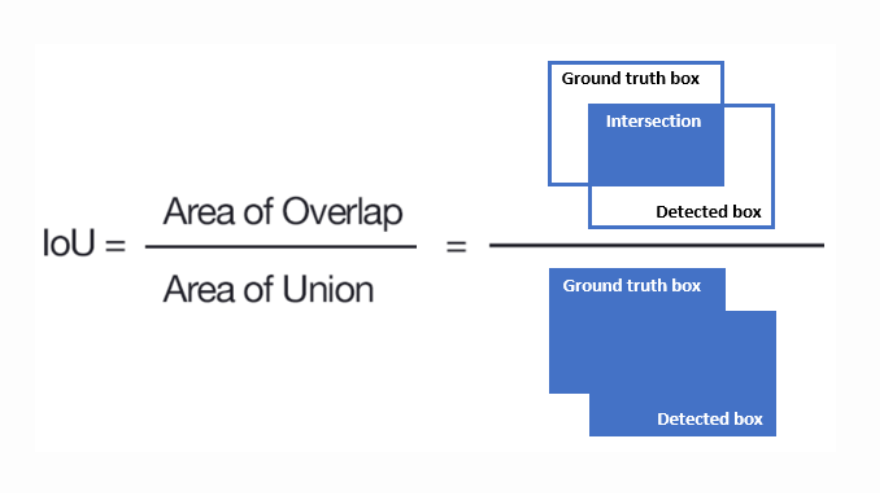

*(top) Diagram for IoU, Area of overlap is also called Intersection Area.*

Intersection over Union (IoU) is a fundamental metric used in object detection and computer vision to evaluate the accuracy of bounding boxes. A bounding box is a rectangular area drawn around an object of interest in an image. 

IoU measures the overlap between two bounding boxes: the predicted box (generated by a model) and the ground truth box (the actual location of the object). It calculates the ratio of the intersection area (the overlap between the two boxes) to the union area (the combined area of both boxes).

$ IoU = \frac{(Intersection Area)}{(Union Area)} $

- IoU values range from 0 to 1.
- A higher IoU indicates a better overlap between the predicted and ground truth boxes, meaning the model has accurately detected the object.
- An IoU of 1 represents a perfect overlap, while an IoU of 0 indicates no overlap.

### mAP

The Mean Average Precision mAP is calculated by finding Average Precision(AP) for each class and then average over a number of classes.

$mAP = \frac{1}{N} \sum^N_{i=1} AP_i$

The mAP incorporates the trade-off between precision and recall and considers both false positives (FP) and false negatives (FN). This property makes mAP a suitable metric for most detection applications.


## Comparison

### Base model

In [33]:
evaluate_function("facebook/detr-resnet-50")

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
  0%|          | 0/4 [00:00<?, ?it/s]The `max_size` parameter is deprecated and will

Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.001
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.007
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.028
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.007
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

### 30 epoch model

In [39]:
evaluate_function(model_path)

  0%|          | 0/4 [00:00<?, ?it/s]The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
100%|██████████| 4/4 [01:46<00:00, 26.56s/it]


Accumulating evaluation results...
DONE (t=0.06s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.205
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.348
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.182
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.091
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.114
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.192
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.182
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.348
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.378
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.113
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.210
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

### 100 epoch model

In [40]:
evaluate_function("devonho/detr-resnet-50_finetuned_cppe5")

Some weights of the model checkpoint at devonho/detr-resnet-50_finetuned_cppe5 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
  0%|          | 0/4 [00:00<?, ?it/s]The `max_size` parameter is depr

Accumulating evaluation results...
DONE (t=0.08s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.326
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.657
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.255
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.173
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.178
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.418
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.268
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.468
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.484
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.203
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.301
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

### Interpretations

- The mean Average Precision (mAP) at different Intersection over Union (IoU) metrics reveals a substantial enhancement in the model's performance after 100 epochs.

- The mAP values significantly increase across various epoch training (0, 30, 100), indicating a marked improvement in the model's object detection capabilities.

- This suggests that the additional training epochs have led to a more accurate and robust model, capable of detecting objects with greater precision and confidence.

# Inference

with 100 epoch model

Some weights of the model checkpoint at devonho/detr-resnet-50_finetuned_cppe5 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Detected Coverall with confidence 0.858 at location [294.66, 78.67, 1725.92, 1077.32]


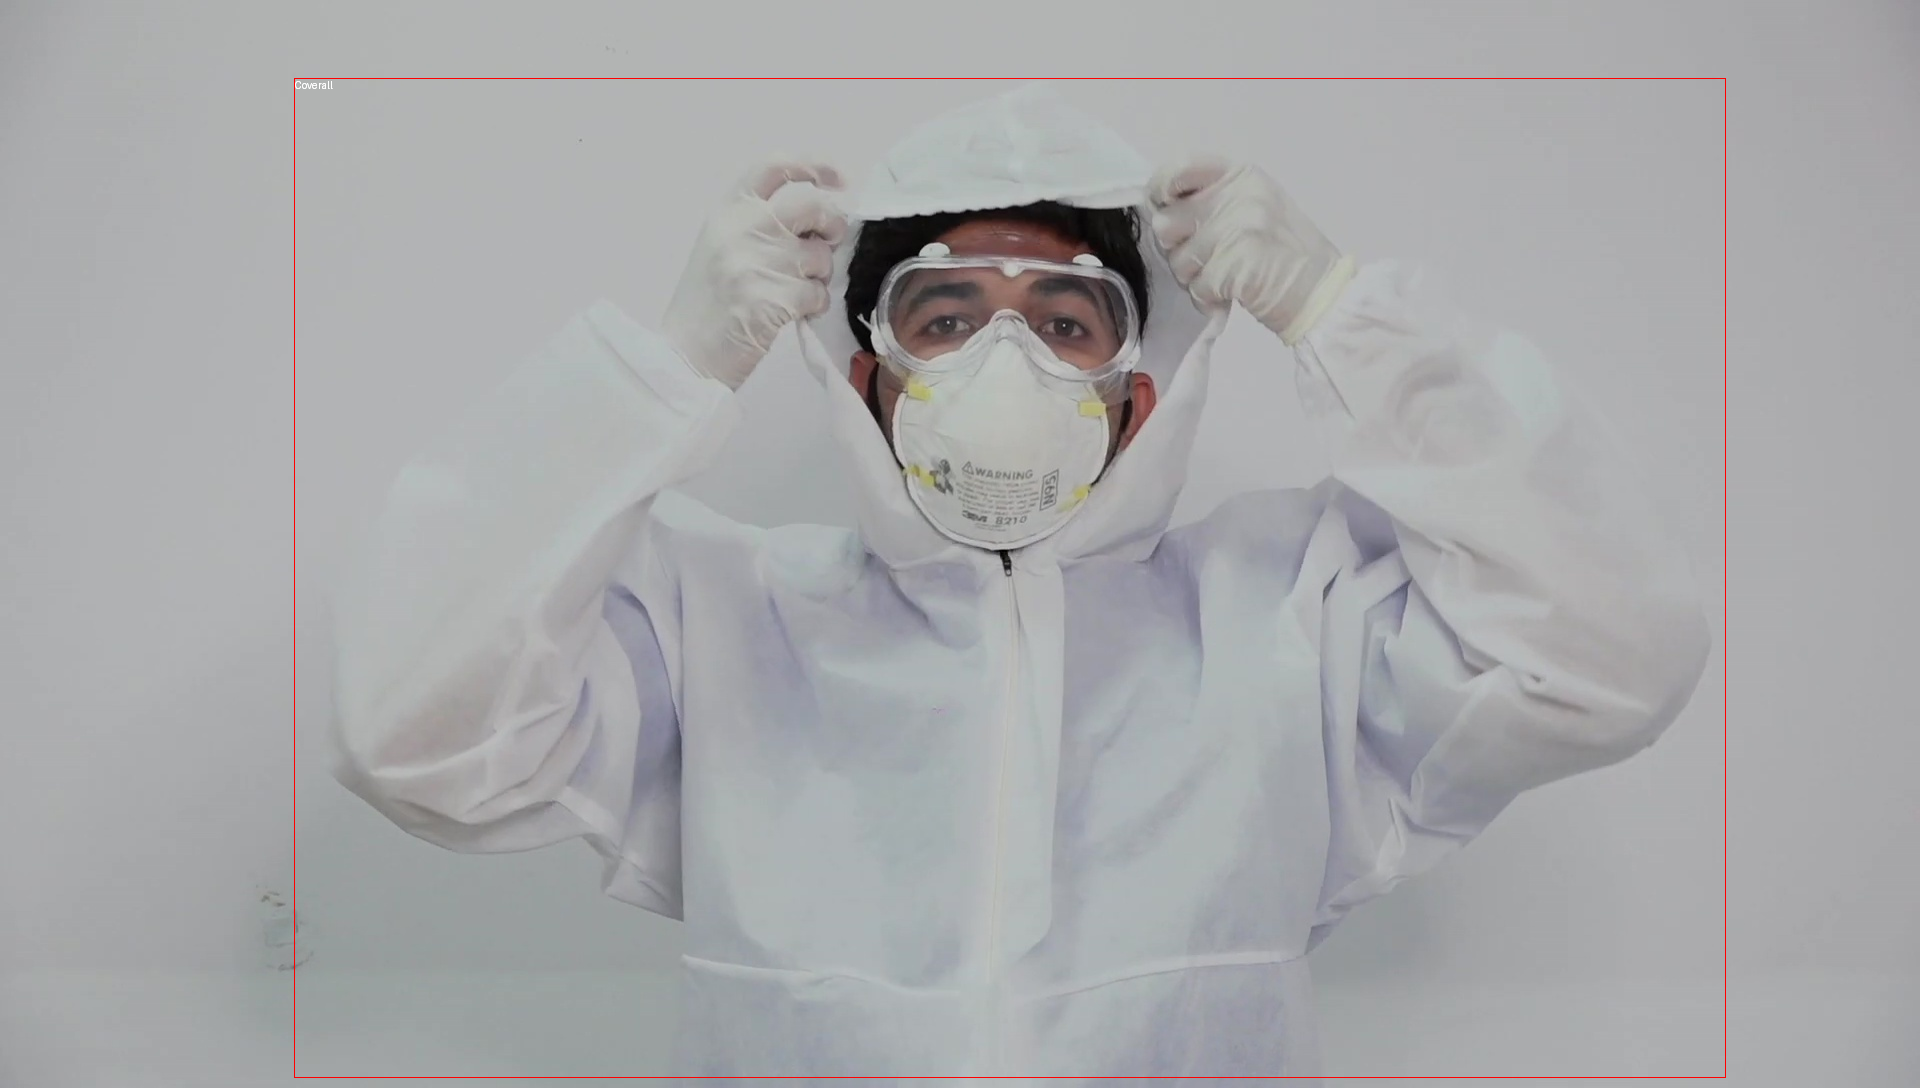

In [41]:
from transformers import pipeline
obj_detector = pipeline("object-detection", model="devonho/detr-resnet-50_finetuned_cppe5")
obj_detector(image)

draw = ImageDraw.Draw(image)

for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    x, y, x2, y2 = tuple(box)
    draw.rectangle((x, y, x2, y2), outline="red", width=1)
    draw.text((x, y), model.config.id2label[label.item()], fill="white")
    print(
        f"Detected {model.config.id2label[label.item()]} with confidence "
        f"{round(score.item(), 3)} at location {box}"
    )

image